In [1]:
%matplotlib inline

# Preprocessing and Spike Sorting Tutorial

- In this introductory example, you will see how to use the :code:`spikeinterface` to perform a full electrophysiology analysis.
- We will first create some simulated data, and we will then perform some pre-processing, run a couple of spike sorting algorithms, inspect and validate the results, export to Phy, and compare spike sorters.


In [2]:
import os
import pickle
import _pickle as cPickle
import glob
import warnings

In [3]:
from collections import defaultdict
import time
import json
from datetime import datetime

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import scipy.signal

In [5]:
# Changing the figure size
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [6]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [7]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

In [8]:
import spikeinterface.core

In [9]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [10]:
import spikeinterface.full as si

In [11]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

# Part 1: Importing Data

## Loading in the Electrophysiology Recording

- We are inputting the electrophsiology recording data with probe information. This should have been created in the prevous notebook in a directory created by Spike Interface. If you had already read in your own electrophsiology recording data with probe information with a different way, then follow these instructions.
    - If you want to use a different directory, then you must either:
        - Change `glob.glob({./path/to/with/*/recording_raw})` to the directory that you have the directories created from Spikeinterface. You can use a wildcard if you have multiple folders. You would replace `{./path/to/with/*/recording_raw}` with the path to either the parent directory or the actual directory containing the electrophsiology recording data read into Spikeinterface.
        - Or change `(file_or_folder_or_dict={./path/to/recording_raw})`. You would replace `{./path/to/recording_raw}` with the path to either the parent directory or the actual directory containing the electrophsiology recording data read into Spikeinterface.

In [12]:
all_recording_preprocessing_directories = glob.glob("./proc/**/preprocessing", recursive=True)

In [13]:
all_recording_preprocessing_directories

['./proc/20220907_140232test/preprocessing']

- If you have more than one recording directory, then you must either:
    - A. Put the index of the file in `all_recording_directories[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `(file_or_folder_or_dict={./path/to/recording_file.rec}`) below. You would replace `{./path/to/recording_file.rec}` with the path of the file for the metadata.

In [14]:
# To be used for all steps
recording_preprocessed = spikeinterface.core.load_extractor(file_or_folder_or_dict=all_recording_preprocessing_directories[0])

In [15]:
type(recording_preprocessed)

spikeinterface.core.binaryrecordingextractor.BinaryRecordingExtractor

## Metadata from the recording file

- This is how you retrieve info from a :code:`RecordingExtractor`...



In [16]:
channel_ids = recording_preprocessed.get_channel_ids()
fs = recording_preprocessed.get_sampling_frequency()
num_chan = recording_preprocessed.get_num_channels()
num_seg = recording_preprocessed.get_num_segments()
duration = recording_preprocessed.get_num_frames()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print('Duration:', duration)
print('Number of hours:', duration/fs/3600)

Channel ids: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31']
Sampling frequency: 20000.0
Number of channels: 32
Number of segments: 1
Duration: 6768567
Number of hours: 0.094007875


- Looking over the recording file

Text(0, 0.5, 'Channels')

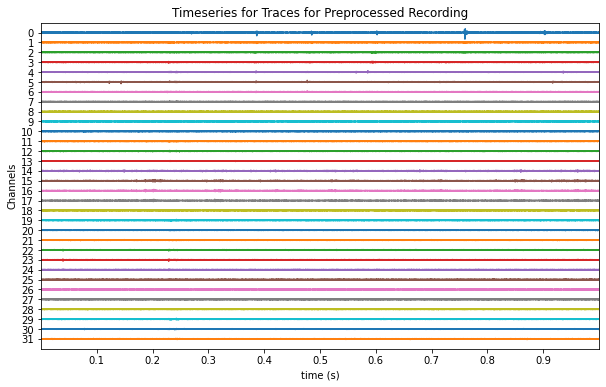

In [17]:
sw.plot_timeseries(recording_preprocessed, show_channel_ids=True)
plt.title("Timeseries for Traces for Preprocessed Recording")
plt.ylabel("Channels")

In [18]:
channel_ids = np.random.choice(recording_preprocessed.channel_ids, size=5, replace=False)

In [19]:
channel_ids = sorted(channel_ids, key=lambda x: float(x))

Text(0, 0.5, 'Channels')

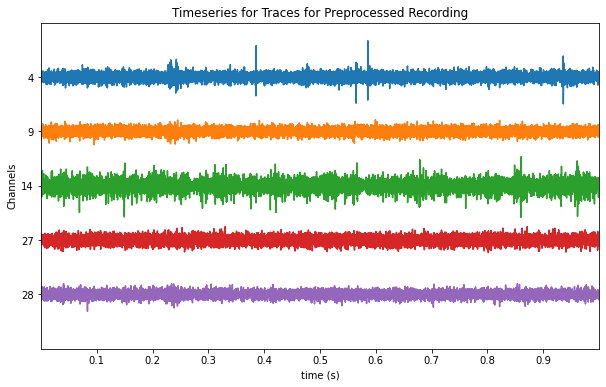

In [20]:

sw.plot_timeseries(recording_preprocessed, channel_ids=channel_ids, show_channel_ids=True)
plt.title("Timeseries for Traces for Preprocessed Recording")
plt.ylabel("Channels")

- Looking over the probe

In [21]:
probe_object = recording_preprocessed.get_probegroup()

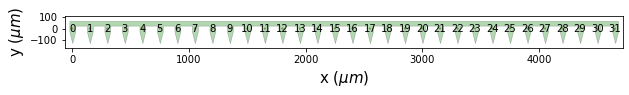

In [22]:
plot_probe_group(probe_object, same_axes=False, with_channel_index=True)
plt.show()

# Part 2: Sorting

Now you are ready to spike sort using the :code:`sorters` module!
Let's first check which sorters are implemented and which are installed



In [23]:
print('Available sorters', ss.available_sorters())

Available sorters ['combinato', 'hdsort', 'herdingspikes', 'ironclust', 'kilosort', 'kilosort2', 'kilosort2_5', 'kilosort3', 'klusta', 'mountainsort4', 'pykilosort', 'spykingcircus', 'tridesclous', 'waveclus', 'yass']


The :code:`ss.installed_sorters()` will list the sorters installed in the machine.
We can see we have mountainsort4 and Tridesclous installed.
Spike sorters come with a set of parameters that users can change.
The available parameters are dictionaries and can be accessed with:



In [24]:
sorter_name = 'mountainsort4'

In [25]:
print(ss.get_default_params(sorter_name))

{'detect_sign': -1, 'adjacency_radius': -1, 'freq_min': 300, 'freq_max': 6000, 'filter': True, 'whiten': True, 'num_workers': 1, 'clip_size': 50, 'detect_threshold': 3, 'detect_interval': 10}


Let's run a spike sorter and change one of the parameter, say, the detect_threshold:



In [26]:
ss_params = ss.get_default_params(sorter_name).copy()

- Changing the default parameters for these parameters
    - These are the parameters changed in Maya's video

In [27]:
ss_params['adjacency_radius'] = 100
ss_params['detect_sign'] = 0
ss_params['filter'] = False
ss_params['num_workers'] = 8
ss_params['detect_interval'] = 30
ss_params['detect_threshold']=3.5

## Creating a folder for Spike Sorting Output

In [28]:
all_parent_recording_directories = glob.glob("./proc/*")

In [29]:
all_parent_recording_directories

['./proc/20220907_140232test']

- If you have more than one recording directory, then you must either:
    - A. Put the index of the file in `all_recording_directories[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `(file_or_folder_or_dict={./path/to/recording_file.rec}`) below. You would replace `{./path/to/recording_file.rec}` with the path of the file for the metadata.

In [30]:
parent_output_directory = all_parent_recording_directories[0]

- Creating a directory within the recording directory for preprocessing and saving the preprocessed recordings into it 

In [31]:
parent_spikesorting_output_directory = os.path.join(parent_output_directory, sorter_name)


In [32]:
parent_spikesorting_output_directory

'./proc/20220907_140232test/mountainsort4'

In [33]:
current_date = datetime.today().strftime('%Y_%m_%d')

dated_spikesorting_output_directory = os.path.join(parent_spikesorting_output_directory, current_date)

In [34]:
dated_spikesorting_output_directory

'./proc/20220907_140232test/mountainsort4/2022_09_12'

In [35]:
os.makedirs(dated_spikesorting_output_directory, exist_ok=True)

- Sorting usually takes at least a hour. Uncomment the code block below to run it. 

In [36]:
all_sorter_methods = [sorter for sorter in dir(ss) if sorter_name in sorter and "run" in sorter]

In [37]:
all_sorter_methods

['run_mountainsort4']

In [38]:
sorter_method_name = all_sorter_methods[0]

In [39]:
sorter_method_call = getattr(ss, sorter_method_name)

In [40]:
sorter_method_call

<function spikeinterface.sorters.runsorter.run_mountainsort4(*args, **kwargs)>

In [41]:
child_spikesorting_output_directory = os.path.join(dated_spikesorting_output_directory,"ss_output")

In [42]:
if not os.path.exists(child_spikesorting_output_directory):
    start = time.time()
    sorter_method_call(recording=recording_preprocessed,
                                  verbose=True,
                                   output_folder=child_spikesorting_output_directory ,
                                   **ss_params)
    print("Sorting finished in: ", time.time() - start)
else:
    warnings.warn("""Directory already exists for: {}. 
    Either continue on if you are satisfied with the previous run 
    or delete the directory and run this cell again""".format(dated_spikesorting_output_directory))

/nancy/user/riwata/projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/MEArec/tools.py:19: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if StrictVersion(yaml.__version__) >= StrictVersion('5.0.0'):
/nancy/user/riwata/projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/MEArec/simulate_cells.py:19: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if StrictVersion(yaml.__version__) >= StrictVersion('5.0.0'):
/nancy/user/riwata/projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/MEArec/generators/templategenerator.py:13: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if StrictVersion(yaml.__version__) >= StrictVersion('5.0.0'):
/nancy/user/riwata/projects/spike_sorting/bin/conda_environments/env/spike_interface_e

whitenning
Mountainsort4 use the OLD spikeextractors mapped with RecordingExtractorOldAPI
Using 8 workers.
Using tmpdir: /tmp/tmp9ocg2bl3
Num. workers = 8
Preparing /tmp/tmp9ocg2bl3/timeseries.hdf5...
Preparing neighborhood sorters (M=32, N=6768567)...
Neighboorhood of channel 14 has 1 channels.
Detecting events on channel 15 (phase1)...
Neighboorhood of channel 7 has 1 channels.
Detecting events on channel 8 (phase1)...
Neighboorhood of channel 25 has 1 channels.
Detecting events on channel 26 (phase1)...
Neighboorhood of channel 28 has 1 channels.
Detecting events on channel 29 (phase1)...
Neighboorhood of channel 21 has 1 channels.
Detecting events on channel 22 (phase1)...
Neighboorhood of channel 27 has 1 channels.
Detecting events on channel 28 (phase1)...
Elapsed time for detect on neighborhood: 0:00:03.235831
Num events detected on channel 15 (phase1): 7435
Computing PCA features for channel 15 (phase1)...
Elapsed time for detect on neighborhood: 0:00:03.434956
Num events detec

Re-assigning events for channel 25 (phase1)...
Neighboorhood of channel 3 has 1 channels.
Detecting events on channel 4 (phase1)...
Clustering for channel 5 (phase1)...
Elapsed time for detect on neighborhood: 0:00:02.660455
Num events detected on channel 30 (phase1): 5058
Computing PCA features for channel 30 (phase1)...
Elapsed time for detect on neighborhood: 0:00:02.486314
Num events detected on channel 17 (phase1): 2292
Computing PCA features for channel 17 (phase1)...
Clustering for channel 30 (phase1)...
Found 3 clusters for channel 5 (phase1)...
Computing templates for channel 5 (phase1)...
Clustering for channel 17 (phase1)...
Re-assigning events for channel 5 (phase1)...
Neighboorhood of channel 1 has 1 channels.
Detecting events on channel 2 (phase1)...
Elapsed time for detect on neighborhood: 0:00:02.771755
Num events detected on channel 18 (phase1): 3019
Computing PCA features for channel 18 (phase1)...
Found 2 clusters for channel 30 (phase1)...
Computing templates for ch

/nancy/user/riwata/projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/neo/io/nixio.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_NIX_VER = Version("1.5.0")
/nancy/user/riwata/projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/neo/io/neomatlabio.py:30: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if version.LooseVersion(scipy.version.version) < '0.12.0':
/nancy/user/riwata/projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/nancy/user/riwata/projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/MEArec/tools.py:19: DeprecationWarning: distu

Neighboorhood of channel 30 has 1 channels.
Computing PCA features for channel 31 (phase2)...
Neighboorhood of channel 12 has 1 channels.
Computing PCA features for channel 13 (phase2)...
Neighboorhood of channel 15 has 1 channels.
Computing PCA features for channel 16 (phase2)...
Neighboorhood of channel 2 has 1 channels.
Computing PCA features for channel 3 (phase2)...
Neighboorhood of channel 25 has 1 channels.
Computing PCA features for channel 26 (phase2)...
Neighboorhood of channel 19 has 1 channels.
Computing PCA features for channel 20 (phase2)...
No duplicate events found for channel 25 in phase2
Clustering for channel 26 (phase2)...
No duplicate events found for channel 30 in phase2
Clustering for channel 31 (phase2)...
No duplicate events found for channel 19 in phase2
Clustering for channel 20 (phase2)...
No duplicate events found for channel 2 in phase2
Clustering for channel 3 (phase2)...
No duplicate events found for channel 12 in phase2
Clustering for channel 13 (phase2

/nancy/user/riwata/projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/neo/io/nixio.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_NIX_VER = Version("1.5.0")
/nancy/user/riwata/projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/neo/io/neomatlabio.py:30: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if version.LooseVersion(scipy.version.version) < '0.12.0':
/nancy/user/riwata/projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/nancy/user/riwata/projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/MEArec/tools.py:19: DeprecationWarning: distu

Preparing output...
Done with ms4alg.
Cleaning tmpdir::::: /tmp/tmp9ocg2bl3
mountainsort4 run time 47.64s
Sorting finished in:  47.8665406703949


In [43]:
spike_sorted_object = ss.read_sorter_folder(child_spikesorting_output_directory)

- Plotting the Rasters

Text(0, 0.5, 'Unit IDs')

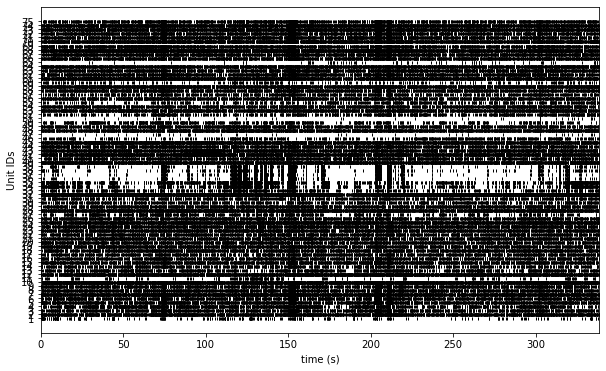

In [44]:
sw.plot_rasters(spike_sorted_object)
plt.ylabel("Unit IDs")